# OO Based Approach

https://www.perplexity.ai/search/what-is-the-best-practice-for-GsIM4MKiSryinGQldzwVug

# EEG Dataset Processing Pipeline

Scope:
- Process a raw EEG dataset 
- Dataset containing the results of an EEG study on multiple subjects
- Dataset that has been downloaded from OpenNeuro, and structured as per the BIDS standard, and in EEGLab '.set' format

The Pipeline Stages (For each subject in an EEG study dataset):
- EEG Dataset Load - Get the raw source EEG signal data
- EEG Preprocessing - Execute filtering etc of the raw EEG time series data
- Power Spectra Calculate - Calculate the power spectra, for all channels recorded
- Spectral Parameterisation - Determine the best fitting Aperiodic and Periodic components
- Features Set - Collate the subject and EEG data into a features set, Pandas Dataframe
- Save Features Set - Save study and subject meta data and the feature set for separate ML use 


## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1

EEG specific dependencies:
- mne = 1.9.0
- specparam = 2.0.0rc3

## Python-MNE

Used for Import:
- MNE-Python: https://mne.tools/stable/index.html
- The Brain Imaging Data Structure (BIDS): https://bids.neuroimaging.io

Used for Power Spectrum Calculate
- MNE vs NeuroDSP: https://www.perplexity.ai/search/using-python-which-package-is-zOoiPqUvTnKbO.QfgmPsJQ

Formats:
- Assumes OpenNeuro, BIDS compliant datasets manually downloaded into the defined folders structure
- Assumes EEGLab '.set' format


## Spectral Parameterisation

Spectral Parameterisation:
- The Aperiodic Methods project - Documentation: https://aperiodicmethods.github.io/docs/index.html and Repo: in https://github.com/AperiodicMethods/AperiodicMethods
- And cite: https://www.biorxiv.org/content/10.1101/2024.09.15.613114v1

Documentation:
- SpecParam: https://specparam-tools.github.io and https://github.com/fooof-tools
- FOOOF: https://fooof-tools.github.io/fooof/ and https://github.com/fooof-tools/fooof

FOOOF vs SpecPram:
- FOOOF: More stable and used but deprecated
- SpecParam: Release candidate but some improved model/fit selection: https://pmc.ncbi.nlm.nih.gov/articles/PMC11326208/
- Summary: https://www.perplexity.ai/search/using-python-which-package-is-M7kzhERoTLuCrIKbXxN9sQ


## Imports


In [1]:
# Not availble through a Conda install/environment
%pip install specparam

Note: you may need to restart the kernel to use updated packages.


In [2]:
# General imports
import os
import gc
from datetime import datetime
import math
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# MNE-Python
import mne

# Specparam
from specparam import SpectralGroupModel
from specparam.plts.spectra import plot_spectra

In [3]:
# Check the version of the module
from specparam import __version__ as specparam_version
print('Current fooof version:', specparam_version)

Current fooof version: 2.0.0rc3


# Classes & Functions


In [4]:
# A utility function to establish relative paths for a given folder
def get_folder_path(folder_name):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, folder_name)
    if not os.path.isdir(folder_path):
        raise Exception(f'Directory not found: {folder_path}')  
     
    return folder_path

# Utility function to check for the existence of a file in a given directory
def get_file_path(folder, file_name):
    file_path = os.path.join(folder, file_name)
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f'File not found: {file_path}')
    return file_path

In [5]:
# Class for the study / dataset information

class Study:
    """
    Class for information on an EEG study

    Attributes
    ----------
    TBD
    """

    # BIDS structure source of subjects data
    __subjects_source_file = 'participants.tsv'

    def __init__(self, dataset_folder_path, dataset_name):
        """
        Initialise Study instance.

        Parameters
        ----------
        dataset_folder : str
        dataset_name : str

        Returns
        -------
        Study : class instance
        """

        # Input validation - Valid Dataset
        datasets_list = os.listdir(dataset_folder_path)
        datasets_list = [d for d in datasets_list if d.startswith('ds') and os.path.isdir(os.path.join(dataset_folder_path, d))]

        if dataset_name not in datasets_list:
            raise ValueError(f"Dataset '{dataset_name}' not found in available datasets: {datasets_list}")
        dataset_path = os.path.join(dataset_folder_path, dataset_name)
        if not os.path.exists(dataset_path):
            raise FileNotFoundError(f"Path does not exist: {dataset_path}")
        subjects_file = os.path.join(dataset_folder_path, dataset_name, self.__subjects_source_file)
        if not os.path.isfile(subjects_file):
            raise ValueError(f'File not found: {subjects_file}')
        
        # Private Attributes
        # TODO: Any private attributes?

        # Public Attributes
        self.dataset_name = dataset_name
        self.dataset_path = dataset_path
        self.subjects_df = self._create_subjects_df(subjects_file)

    def _create_subjects_df(self, subjects_csv):
        # Read the datset csv file to get selected subjects data
        try:
            temp_subjects_df = pd.read_csv(subjects_csv, sep='\t')
        except Exception as e:
            raise IOError(f"Failed to read subjects file '{subjects_csv}': {e}")
        subjects_df = temp_subjects_df[['participant_id', 'AGE', 'GENDER', 'TYPE']].copy()
        subjects_df.columns = ['subject_id', 'age', 'gender', 'pd']

        return subjects_df
    
    # Public functions
    



In [ ]:
# Subject Class with all EEG processing etc results

class Subject:
    """
    Class for information on an individual subject within an EEG study.
    And execution of processing stages.

    Attributes
    ----------
    eeg_raw : raw EEG signal data, all channels
    spectra_method, spectra_fmin, spectra_fmax
    """

    def __init__(self, study, subject_id):
        """
        Initialise Subject instance.

        Parameters
        ----------
        study : Study class
        subject_id : str

        Returns
        -------
        Subject : class instance
        """

        if 'verbose' in globals() and verbose:
            mne.set_log_level('DEBUG')
        else:
            mne.set_log_level('WARNING')

        # BIDS File Structure
        #dataset_root = 
        #dataset_name = 
        subject = subject_id
        session = ''
        task = 'Rest'
        datatype='eeg'

        # EEGLab .set file name
        temp_path = os.path.join(study.dataset_path, subject, session, datatype)
        temp_file_name = subject + '_task-' + task + '_' + datatype + '.set'
        eeg_lab_file_path = get_file_path(temp_path, temp_file_name)

        # Get the raw EEG data & Inspect it
        try:
            self.eeg_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True)
        except Exception as e:
            raise ValueError(f"Failed to load EEG data for subject {subject}: {e}") 

        # TODO: Any raw data to keep in class? eg nchannels, sampling frequency ......      

    def inspect_EEG_Raw(self):
        """
        Summarise the EEG information
        """

        print(f"EEG Raw Description: {self.eeg_raw.info['description']} on {self.eeg_raw.info['meas_date']}")
        print(self.eeg_raw)
        print(self.eeg_raw.info)
    
    def plot_time(self, channel):
        """
        Plot time series for a given channel
        """

        # TODO: Add an inline plot of all the channels time series ... NeuroDSP if not MNE

        print('Quick Selected Channel Plot')
        fs = self.eeg_raw.info['sfreq']
        t_start = 0
        t_stop = int(t_start + (10 * fs))

         # Extract an example channel
        sig, times = self.eeg_raw.get_data(mne.pick_channels(self.eeg_raw.ch_names, [channel]),
                                start=t_start, stop=t_stop,
                                return_times=True)
        sig = np.squeeze(sig)

        # Plot Channel Time Series
        plt.figure(figsize=(12, 4))
        plt.plot(times, sig, color='blue')
        plt.title(f"EEG Time Series - Channel {channel}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (uV)")
        plt.tight_layout()
        plt.show()

    def spectra(self, method='welch', min_frequency=1, max_frequency=75):
        """
        Calculate the power spectra. For all channels

        Parameters
        ----------
        method : eg 'welch'
        min_frquency : int
        max_frequency : int
        """

        print(f"PSD using {method} method for frequencies {min_frequency} to {max_frequency} Hz")
        try:
            self.spectra_result = self.eeg_raw.compute_psd(method=method, 
                                                           fmin=min_frequency, fmax=max_frequency)
        except Exception as e:
            raise Exception(f"Error calculating spectra: {e}")

        self.spectra_method = method
        self.spectra_fmin = min_frequency
        self.spectra_fmax = max_frequency

    def inspect_Spectra(self):
        """
        Summarise the Spectra Information
        """

        print(self.spectra_result.info)

        freqs = self.spectra_result.freqs
        powers = self.spectra_result.get_data(return_freqs=False)
        n_channels = powers.shape[0]
        n_frequencies = powers.shape[1]
        freq_resolution = freqs[1] - freqs[0]
        print(f'Spectra Group:')
        print(f'- {n_channels} channels & {n_frequencies} frequencies')
        print(f'- Frequency Range: {freqs.min():.0f} to {freqs.max():.0f} Hz')
        print(f'- Frequency resolution {freq_resolution:.2f} Hz')

    def plot_Spectra(self, channel):
        """
        Plot PSD
        """

        freqs = self.spectra_result.freqs
        powers = self.spectra_result.get_data(return_freqs=False)

        print('Quick PSD')
        self.spectra_result.plot()
        plt.show()

         # Log-log plot for all channels
        plt.figure(figsize=(12, 6))
        for idx, ch in enumerate(self.eeg_raw.ch_names):
            plt.loglog(freqs, powers[idx], alpha=0.5, label=ch if idx < 10 else None)  # label only first 10 for clarity
        plt.title(f"Power Spectrum (Log-Log) - All Channels ({self.spectra_method} method)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power ($V^2/Hz$)")
        plt.tight_layout()
        plt.show()

        # Log-lin plot for all channels
        plt.figure(figsize=(12, 6))
        for idx, ch in enumerate(self.eeg_raw.ch_names):
            plt.semilogy(freqs, powers[idx], alpha=0.5, label=ch if idx < 10 else None)  # label only first 10 for clarity
        plt.title(f"Power Spectrum (Log-Lin) - All Channels ({self.spectra_method} method)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power ($V^2/Hz$)")
        plt.tight_layout()
        plt.show()

        # A selected channel
        ch_label = channel
        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        fig.suptitle(f'Power Spectrum - Channel {ch_label} ({self.spectra_method} method)', fontsize=20)
        ax0.set_title('Log/Log')
        ax1.set_title('Log/Lin')
        plot_spectra(freqs, powers[self.eeg_raw.ch_names.index(ch_label)], log_freqs=True, log_powers=True, ax=ax0, colors='blue')
        plot_spectra(freqs, powers[self.eeg_raw.ch_names.index(ch_label)], log_powers=True, ax=ax1, colors='blue')
        plt.show()

    def specparam(self,):
        """
        Execute Spectral Parameterisation for the subject group
        Parameters
        ----------
        method : eg 'welch'
        min_frquency : int
        max_frequency : int
        """

        freqs = self.spectra_result.freqs
        powers = self.spectra_result.get_data(return_freqs=False)
        freq_resolution = freqs[1] - freqs[0]
        n_channels = powers.shape[0]
        n_frequencies = powers.shape[1]

        # Spectral Parameterisation
        spm_max_peak_width = 12
        spm_min_peak_height = 0.05
        spm_max_n_peaks = 10
        spm_fit_freq_range = [1, 75]
        spm_aperiodic_mode = 'fixed'
        spm_max_channels = 72
        # TODO: Subject 68 had 66 channels but max should be 63? Check during preprocessing, before FOOOFING

        peak_width_limits = [int(math.ceil(2 * freq_resolution)), spm_max_peak_width]


        print('Extracting Periodic & Aperiodic Components with Parameters:')
        # TODO: No need to save all these? Instead just use fg.get_settings to retrieve
        print(f'- Peak width limits: [{peak_width_limits[0]:.0f}, {peak_width_limits[1]:.0f}]')
        print(f'- Min peak height: {spm_min_peak_height:.2f}')
        print(f'- Max peaks: {spm_max_n_peaks}')
        print(f'- Range: {spm_fit_freq_range}')
        print(f'- Aperiodic Mode: {spm_aperiodic_mode}')

        if n_channels > spm_max_channels:
            raise Exception(f'WARNING: Found: {n_channels} channels, but only {spm_max_channels} max are saved')

        # Initialise SpecParam Group Model
        self.fg = SpectralGroupModel(peak_width_limits=peak_width_limits, 
                                    max_n_peaks=spm_max_n_peaks, min_peak_height=spm_min_peak_height,
                                    aperiodic_mode=spm_aperiodic_mode)
        # Fit the group of n spectra
        try:
            self.fg.fit(freqs, powers, spm_fit_freq_range, progress='tqdm.notebook')
        except Exception as e:
            raise Exception(f"Error calculating spectra: {e}")
        
    def inspect_SpecParam(self):
        """
        Sumarise the Spectral Parameterisation
        """
        print(f'Settings: {self.fg.get_settings()}')
        # Overall group results
        self.fg.print_results()
        self.fg.plot()
        plt.show()

    def plot_SpecParam(self, channel):
        """
        Plot SpecParam
        """

        # Visualise the fit for a sample single channel within the group
        ch_label = channel
        channel_indx = self.eeg_raw.ch_names.index(channel)

        fm = self.fg.get_model(ind=channel_indx, regenerate=True)
        fm.print_results()

        # fm.plot()
        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
        fig.suptitle(f'Spec Param for Channel: {ch_label}', fontsize=20)
        ax0.set_title('Components - Log/Lin')
        ax1.set_title('Components - Log/Log')
        fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, ax=ax0)
        fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, plt_log=True, ax=ax1)
        plt.show()

    def get_Features(self):
        """
        Get Features for SpecParam
        """
        # TODO: flatten all the rows into a single one for all channels
        return self.fg.to_df(99)
    





# Pipeline Execute


In [7]:
# Establish data paths & check EEG source datasets available
#

# Set progress messages, testing
global verbose
verbose = True
subject_test = 0
test_channel = 'P5'

# Establish Data Folders
eeg_datasets_source_folder = 'Data/EEG_Datasets_Source_exgithub'
eeg_study_features_folder = 'Data/EEG_Datasets_Processed'


eeg_datasets_path = get_folder_path(eeg_datasets_source_folder)
eeg_study_features_path = get_folder_path(eeg_study_features_folder)

# # Get a list of datasets in the EEG datasets source folder
# datasets_list = os.listdir(eeg_datasets_path)
# datasets_list = [d for d in datasets_list if d.startswith('ds') and os.path.isdir(os.path.join(eeg_datasets_path, d))]

print('\n---------------------------------')
print('EEG Pipeline Parameters - Data')
print(f'EEG Source Datasets Folder: {eeg_datasets_path}')
# print('Datasets found:', datasets_list)
print(f'EEG Study Features Folder: {eeg_study_features_path}')

del eeg_datasets_source_folder, eeg_study_features_folder


---------------------------------
EEG Pipeline Parameters - Data
EEG Source Datasets Folder: /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Source_exgithub
EEG Study Features Folder: /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Processed



-----------------------------------------------------------------------------------------------
EEG Pipeline Processing start for study/dataset: ds004584-1.0.0 with 149 subjects

-----------------------------------------------------------------------------------------------
Processing subject: sub-001
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Source_exgithub/ds004584-1.0.0/sub-001/eeg/sub-001_task-Rest_eeg.fdt
Reading 0 ... 140829  =      0.000 ...   281.658 secs...
Cropping annotations 1970-01-01 00:00:00+00:00 - 1970-01-01 00:04:41.660000+00:00
  [0] Keeping  (1970-01-01 00:00:00+00:00 - 1970-01-01 00:00:00+00:00 -> 0.0 - 0.0)
Cropping complete (kept 1)
EEG Raw Description: None on None
<RawEEGLAB | sub-001_task-Rest_eeg.fdt, 63 x 140830 (281.7 s), ~67.8 MiB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)

/var/folders/wd/rhzj_w8570g_y66t6j6mh4zw0000gn/T/ipykernel_36851/4092909024.py:48: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  self.eeg_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True)


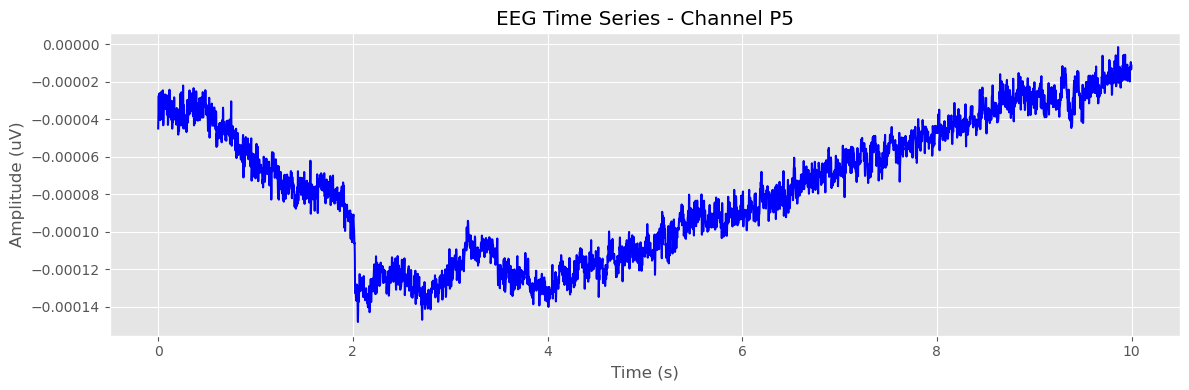


-----------------------------------------------------------------------------------------------
Preprocess raw EEG

-----------------------------------------------------------------------------------------------
Power Spectrum Computation
PSD using welch method for frequencies 1 to 250 Hz
Effective window size : 4.096 (s)
Spectogram using 2048-point FFT on 2048 samples with 0 overlap and hamming window
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 63
 projs: []
 sfreq: 500.0 Hz
>
Spectra Group:
- 63 channels & 1020 frequencies
- Frequency Range: 1 to 250 Hz
- Frequency resolution 0.24 Hz
Quick PSD
Plotting power spectral density (dB=True).
Generating pos outlines with sphere [0.    0.    0.    0.095] from [0.    0.    0.    0.095] for eeg
Generating coords using: [0.    0.  

/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


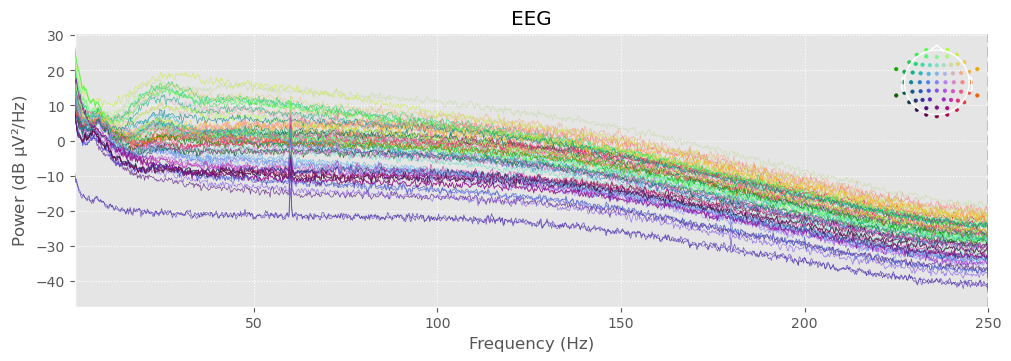

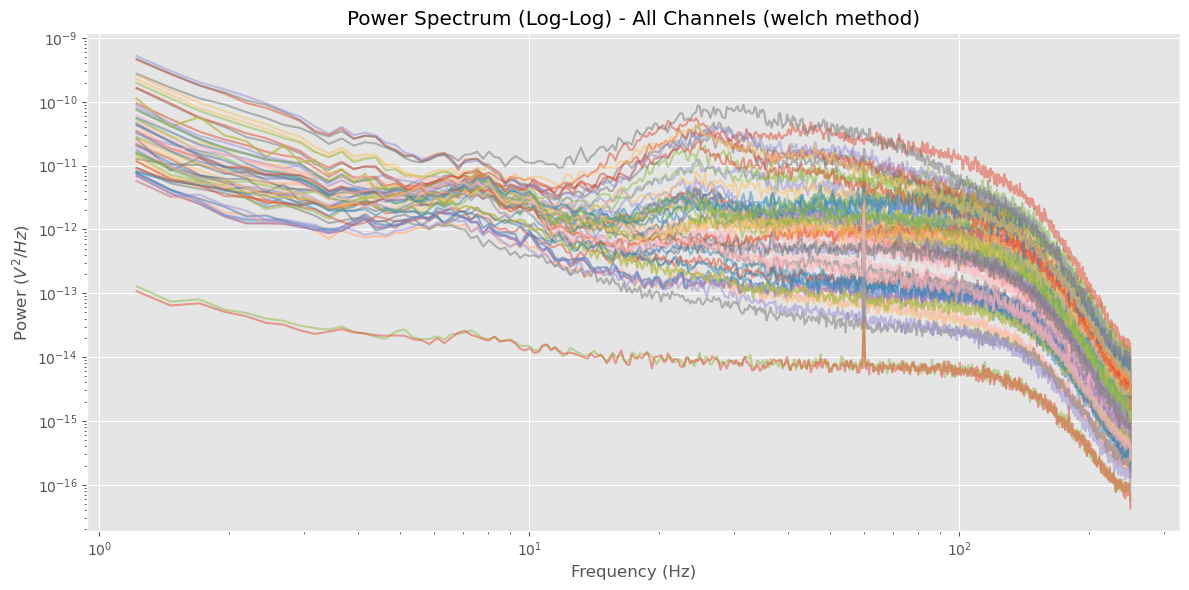

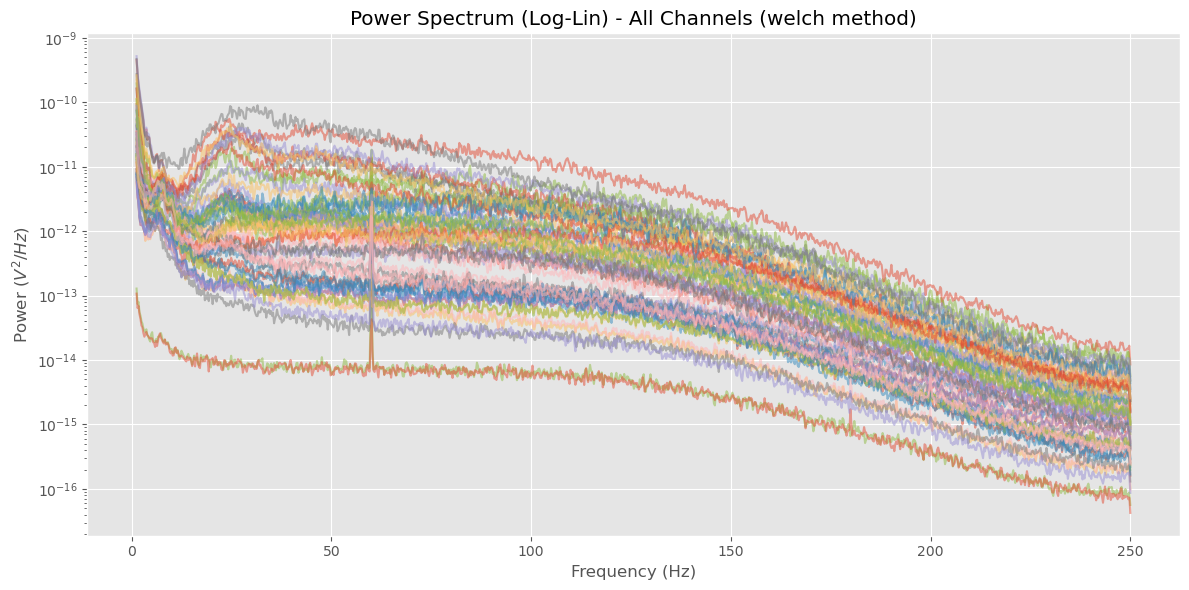

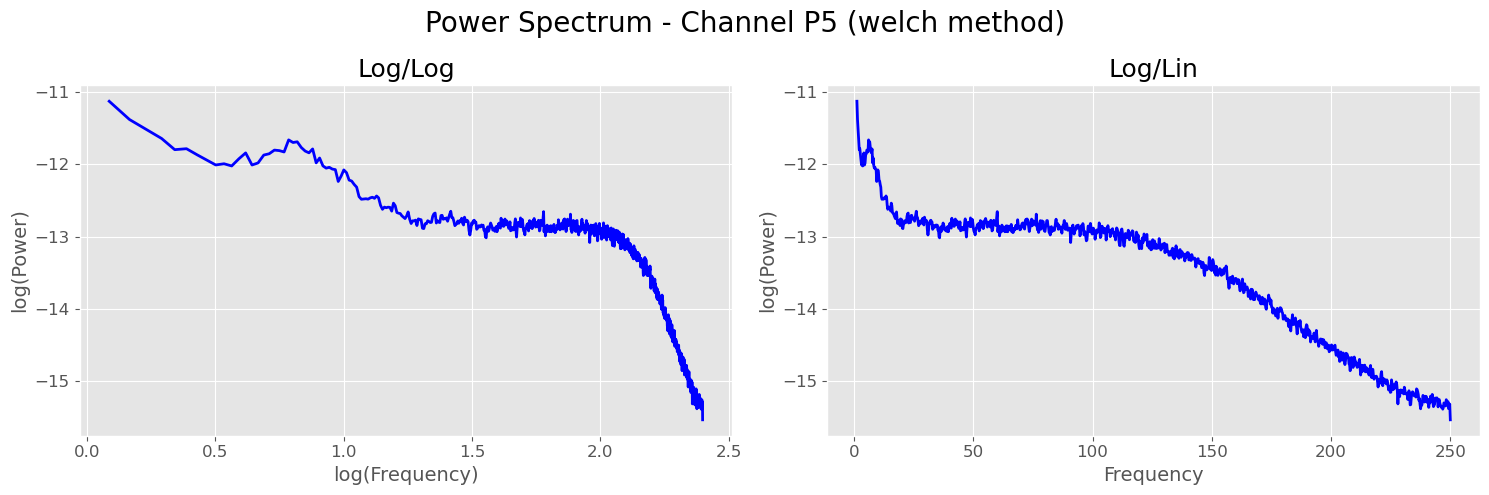


-----------------------------------------------------------------------------------------------
Power Spectral Parameterisation
Extracting Periodic & Aperiodic Components with Parameters:
- Peak width limits: [1, 12]
- Min peak height: 0.05
- Max peaks: 10
- Range: [1, 75]
- Aperiodic Mode: fixed


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]

Settings: ModelSettings(peak_width_limits=[1, 12], max_n_peaks=10, min_peak_height=0.05, peak_threshold=2.0, aperiodic_mode='fixed')
                                                                                                  
                                          GROUP RESULTS                                           
                                                                                                  
                             Number of power spectra in the Group: 63                             
                                                                                                  
                        The model was run on the frequency range 1 - 75 Hz                        
                                 Frequency Resolution is 0.24 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.       

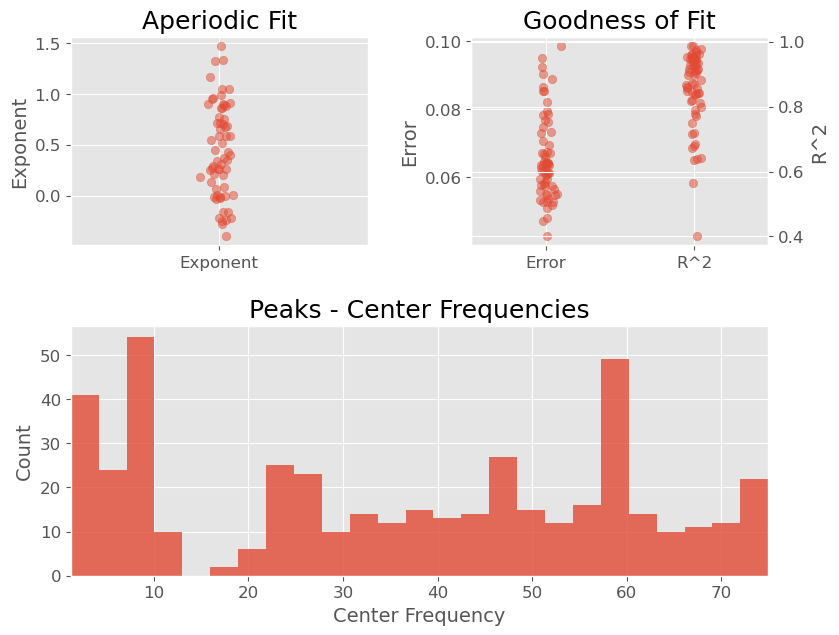

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                        The model was run on the frequency range 1 - 75 Hz                        
                                 Frequency Resolution is 0.24 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.7565, 0.7099                                         
                                                                                                  
                                       8 peaks were found:                                        
          

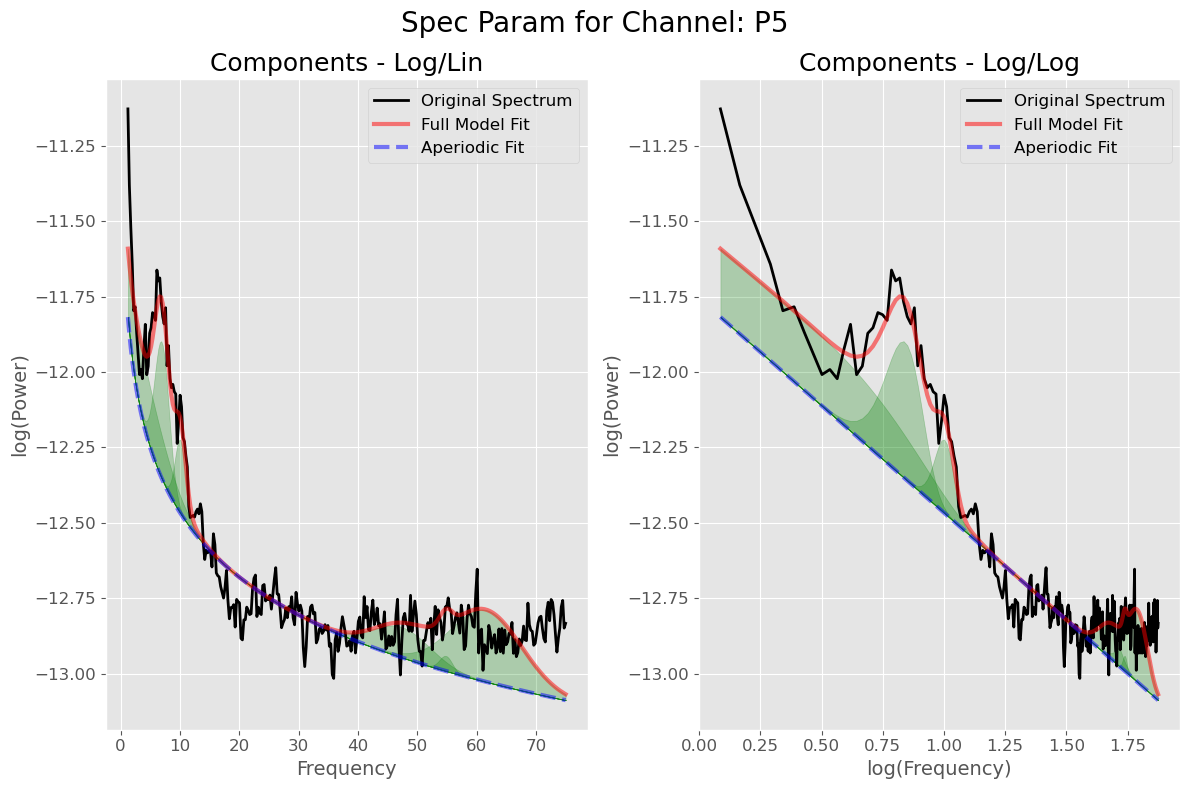

In [8]:
# Execute the end to end pipeline for a given EEG source dataset
#

# Get a valid dataset and extract essential data
study_details = Study(eeg_datasets_path, 'ds004584-1.0.0')

print('\n-----------------------------------------------------------------------------------------------')
print(f'EEG Pipeline Processing start for study/dataset: {study_details.dataset_name} with {len(study_details.subjects_df)} subjects')

# Process each subject in the dataset
for idx, subject in study_details.subjects_df.iterrows():
    # Break for testing
    if int(idx) > subject_test:
        break
    
    print('\n-----------------------------------------------------------------------------------------------')
    print(f"Processing subject: {subject['subject_id']}")

    # Establish a subject with raw EEG data
    subject_process = Subject(study_details, subject['subject_id'])
    if verbose:
        subject_process.inspect_EEG_Raw()
        subject_process.plot_time(test_channel)
    
    # Execute EEG preprocessing
    print('\n-----------------------------------------------------------------------------------------------')
    print(f'Preprocess raw EEG')
    # TODO: Add filtering
    # TODO: Add ICA
    # TODO: Subject 68 had 66 channels but max should be 63? Check during preprocessing, before FOOOFING

    # Calculate Power Spectra
    print('\n-----------------------------------------------------------------------------------------------')
    print(f"Power Spectrum Computation")
    subject_process.spectra('welch', 1, 250)
    if verbose:
        subject_process.inspect_Spectra()
        subject_process.plot_Spectra(test_channel)
    
    # Determine Spectral Parameterisation
    print('\n-----------------------------------------------------------------------------------------------')
    print(f"Power Spectral Parameterisation")
    subject_process.specparam()
    if verbose:
        subject_process.inspect_SpecParam()
        subject_process.plot_SpecParam(test_channel)

    

    


In [9]:
temp = subject_process.get_Features()

In [ ]:
new = temp.copy(deep=True)
new.index = [f'ch_{i}' for i in range(new.shape[0])]


In [ ]:
    def get_Features_single_row(self):
        """
        Flatten the SpecParam features DataFrame so each channel's features are in a single row,
        with columns named as <feature>_<channel>.
        """
        df = self.fg.to_df(10)
        # Add channel name as suffix to each column except 'channel'
        # df = df.set_index('channel')
        # Since there is no 'channel' column, use the row number as the channel index
        df.index = [f'ch_{i}' for i in range(df.shape[0])]
        df_flat = df.rename(lambda col: [f"{col}_{ch}" for ch in df.index] if col != 'channel' else None, axis=1)
        # Flatten columns and create a single row
        df_flat = df_flat.T
        df_flat.index = df_flat.index.map(lambda x: x.replace(' ', '_'))
        single_row = df_flat.T.unstack().to_frame().T
        single_row.columns = [f"{col[1]}_{col[0]}" for col in single_row.columns]
        single_row.reset_index(drop=True, inplace=True)
        return single_row